In [1]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose
from torch_geometric.data import Data

import os,sys

In [2]:
import uproot
import awkward as ak

root_file = "../../data/Dumper_MuGun_FullEta_OneOverPt_1to100_v250514.root"

## Load variable that I'm going to use, from the yml file
import yaml
with open("../configs/dataset_regression.yml", "r") as f:
    config = yaml.safe_load(f)

# Get the list of variables to use
file = uproot.open(root_file)
tree = file[config["tree_name"]]
arr = tree.arrays(library="ak")

# pandas dataframe for easy plotting
import pandas as pd

branches = tree.arrays(library='pd')


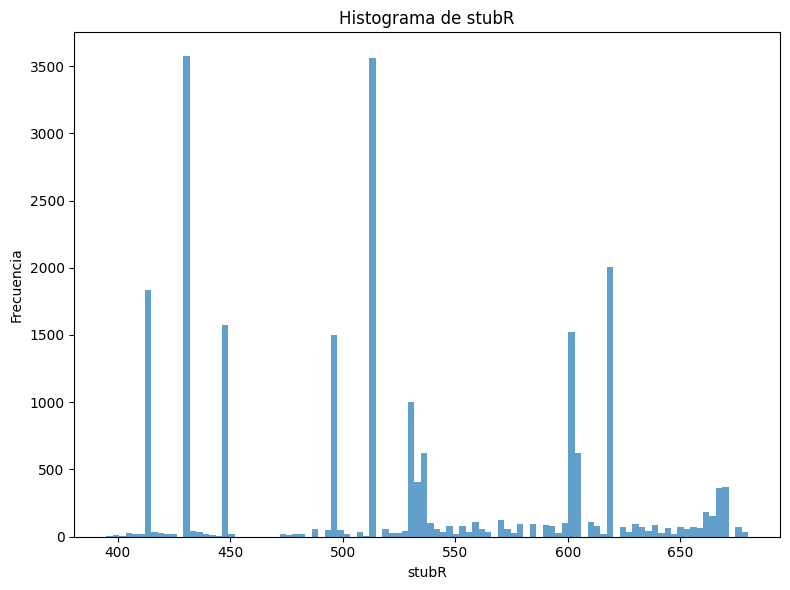

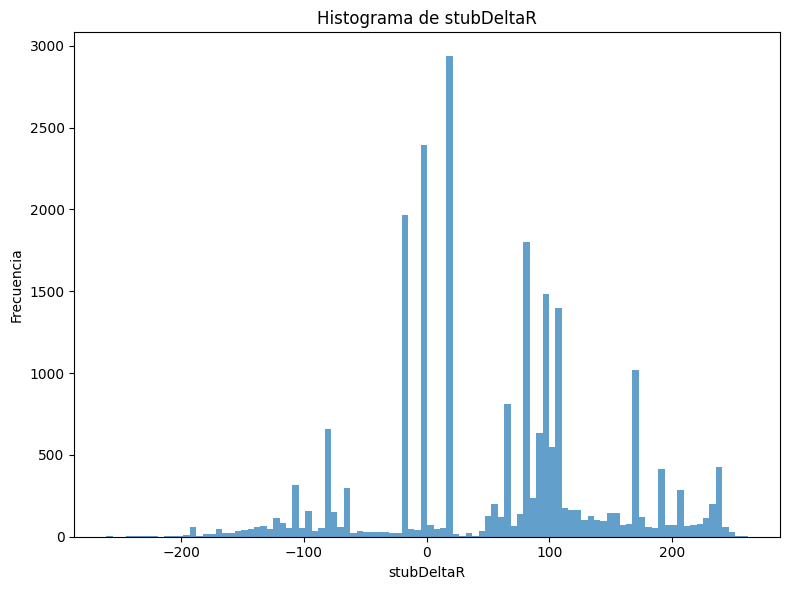

In [5]:
import matplotlib.pyplot as plt

def plot_variable(arr, var_name, bins=50):

    # Convertir la variable a un array de NumPy (aplana si es necesario)
    # Extraer el campo y aplanarlo
    data_field = arr[var_name]
    data_flat = ak.flatten(data_field)
    
    # Convertir a numpy
    data_np = ak.to_numpy(data_flat)
    
    plt.figure(figsize=(8,6))
    plt.hist(data_np, bins=bins, alpha=0.7)
    plt.xlabel(var_name)
    plt.ylabel("Frecuencia")
    plt.title(f"Histograma de {var_name}")
    plt.tight_layout()
    plt.show()


plot_variable(arr, "stubR", bins=100)
plot_variable(arr, "stubDeltaR", bins=100)

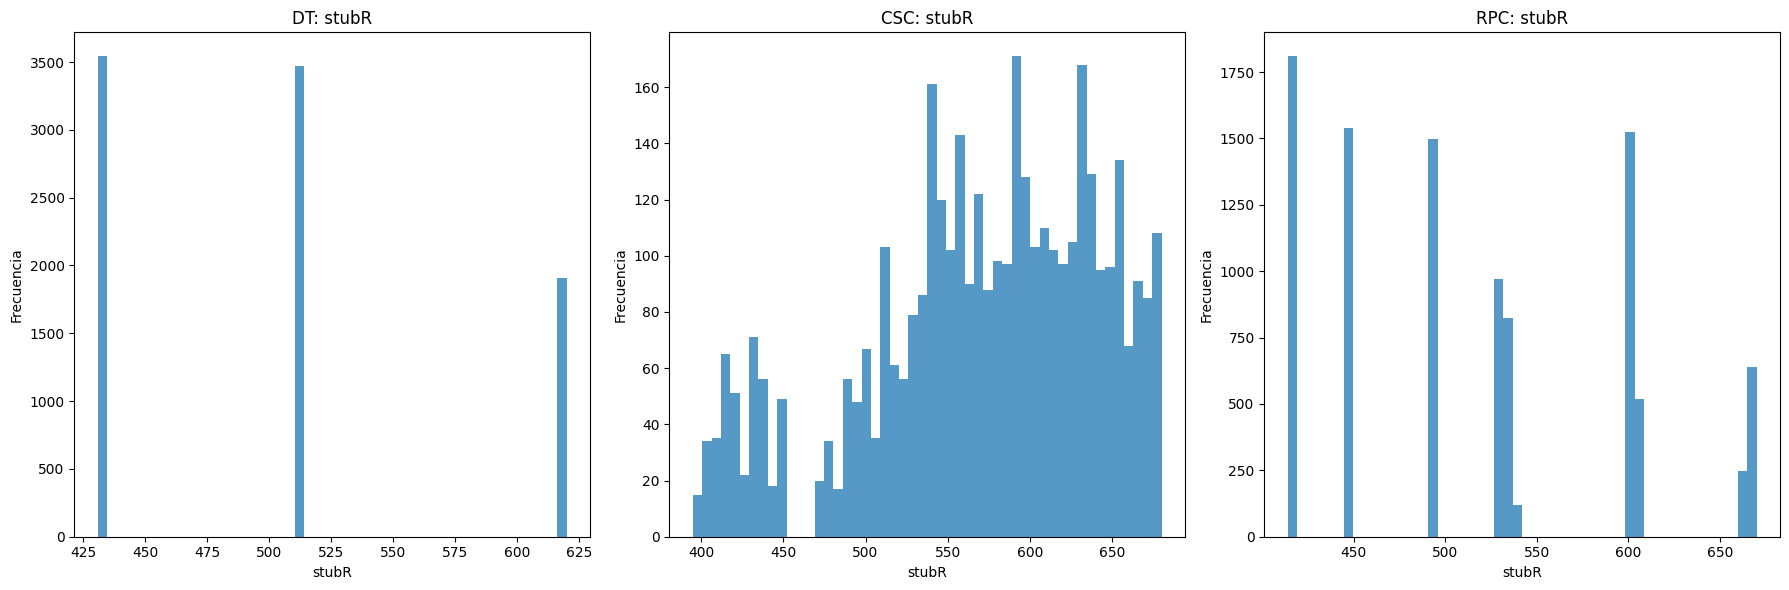

In [18]:
def plot_stubR_by_type(arr):
    # Filtrar los valores de stubR para cada tipo de stub usando ak.mask y aplanarlos
    dt_stubs = ak.flatten(ak.mask(arr.stubR, arr.stubType == 3))
    csc_stubs = ak.flatten(ak.mask(arr.stubR, arr.stubType == 9))
    rpc_stubs = ak.flatten(ak.mask(arr.stubR, arr.stubType == 5))
    
    # Convertir a NumPy
    dt_values = ak.to_numpy(dt_stubs)
    csc_values = ak.to_numpy(csc_stubs)
    rpc_values = ak.to_numpy(rpc_stubs)
    
    # Crear la gráfica con tres subplots
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    
    axs[0].hist(dt_values, bins=50, alpha=0.75)
    axs[0].set_title("DT: stubR")
    axs[0].set_xlabel("stubR")
    axs[0].set_ylabel("Frecuencia")
    
    axs[1].hist(csc_values, bins=50, alpha=0.75)
    axs[1].set_title("CSC: stubR")
    axs[1].set_xlabel("stubR")
    axs[1].set_ylabel("Frecuencia")
    
    axs[2].hist(rpc_values, bins=50, alpha=0.75)
    axs[2].set_title("RPC: stubR")
    axs[2].set_xlabel("stubR")
    axs[2].set_ylabel("Frecuencia")
    
    plt.tight_layout()
    plt.show()

# Llama a la función para plotear
plot_stubR_by_type(arr)

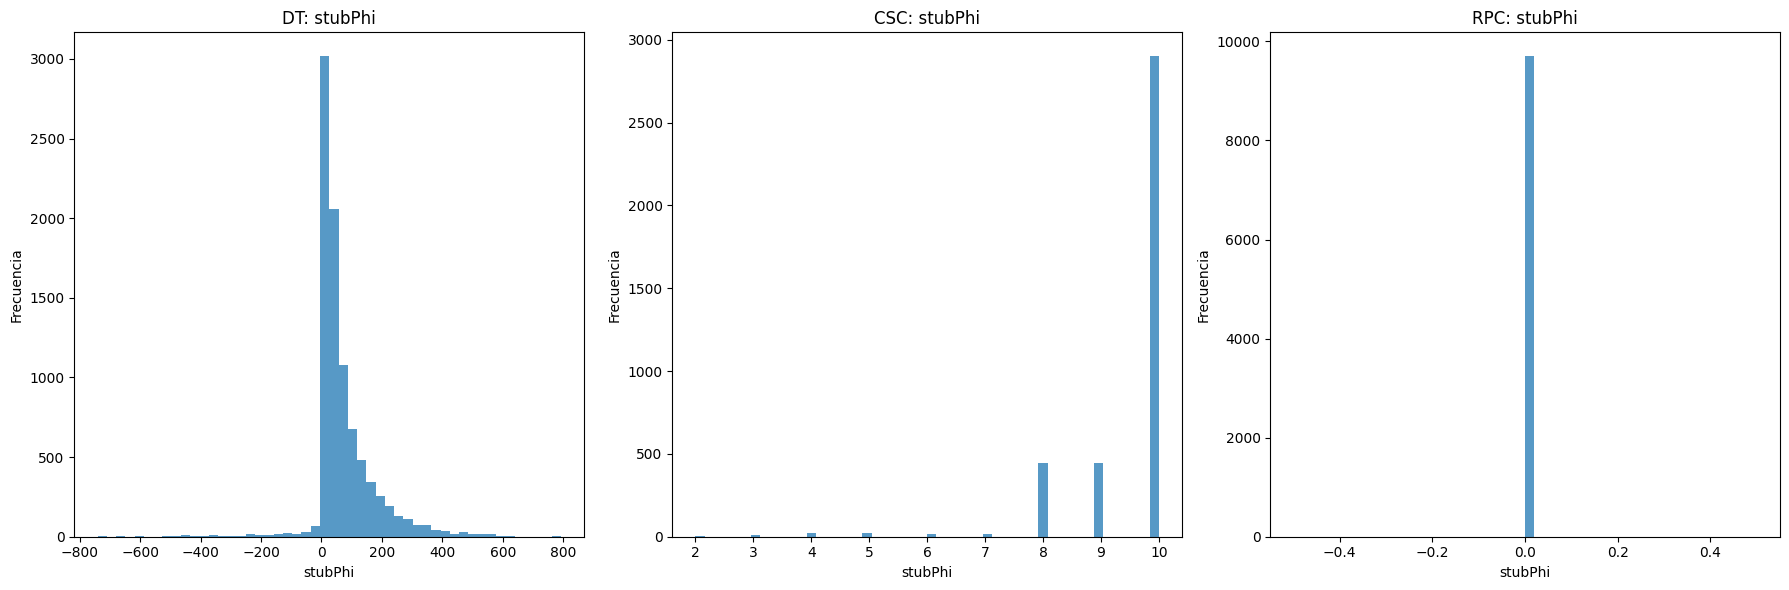

In [20]:
def plot_stubPhi_by_type(arr):
    # Filtrar los valores de stubR para cada tipo de stub usando ak.mask y aplanarlos
    dt_stubs = ak.flatten(ak.mask(arr.stubPhiB, arr.stubType == 3))
    csc_stubs = ak.flatten(ak.mask(arr.stubPhiB, arr.stubType == 9))
    rpc_stubs = ak.flatten(ak.mask(arr.stubPhiB, arr.stubType == 5))
    
    # Convertir a NumPy
    dt_values = ak.to_numpy(dt_stubs)
    csc_values = ak.to_numpy(csc_stubs)
    rpc_values = ak.to_numpy(rpc_stubs)
    
    # Crear la gráfica con tres subplots
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    
    axs[0].hist(dt_values, bins=50, alpha=0.75)
    axs[0].set_title("DT: stubPhi")
    axs[0].set_xlabel("stubPhi")
    axs[0].set_ylabel("Frecuencia")
    
    axs[1].hist(csc_values, bins=50, alpha=0.75)
    axs[1].set_title("CSC: stubPhi")
    axs[1].set_xlabel("stubPhi")
    axs[1].set_ylabel("Frecuencia")
    
    axs[2].hist(rpc_values, bins=50, alpha=0.75)
    axs[2].set_title("RPC: stubPhi")
    axs[2].set_xlabel("stubPhi")
    axs[2].set_ylabel("Frecuencia")
    
    plt.tight_layout()
    plt.show()

# Llama a la función para plotear
plot_stubPhi_by_type(arr)

In [11]:
import numpy as np
from converter import HW_ETA_TO_ETA_FACTOR

def get_stub_r(stubTypes, stubEta, stubLayer, stubQuality):

    stubTypes = ak.to_list(stubTypes)
    stubEta = ak.to_list(stubEta)
    stubLayer = ak.to_list(stubLayer)
    stubQuality = ak.to_list(stubQuality)

    rs = []
    for stubType, stubEta, stubLayer, stubQuality in zip(stubTypes, stubEta, stubLayer, stubQuality):
        r = None
        if stubType == 3:  # DTs
            if stubLayer == 0:
                r = 431.133
            elif stubLayer == 2:
                r = 512.401
            elif stubLayer == 4:
                r = 617.946

            # Low-quality stubs are shifted by 23.5/2 cm
            if stubQuality == 2 or stubQuality == 0:
                r = r - 23.5 / 2
            elif stubQuality == 3 or stubQuality == 1:
                r = r + 23.5 / 2

        elif stubType == 9:  # CSCs
            if stubLayer == 6:
                z = 690  # ME1/3
            elif stubLayer == 9:
                z = 700  # M1/2
            elif stubLayer == 7:
                z = 830
            elif stubLayer == 8:
                z = 930
            r = z / np.cos(np.tan(2 * np.arctan(np.exp(-stubEta * HW_ETA_TO_ETA_FACTOR))))
        elif stubType == 5:  # RPCs, but they will be shut down because they leak poisonous gas
            r = 999.
            if stubLayer == 10:
                r = 413.675  # RB1in
            elif stubLayer == 11:
                r = 448.675  # RB1out
            elif stubLayer == 12:
                r = 494.975  # RB2in
            elif stubLayer == 13:
                r = 529.975  # RB2out
            elif stubLayer == 14:
                r = 602.150  # RB3
            elif stubLayer == 15:
                z = 720  # RE1/3
            elif stubLayer == 16:
                z = 790  # RE2/3
            elif stubLayer == 17:
                z = 970  # RE3/3
            if r == 999.:
                r = z / np.cos(np.tan(2 * np.arctan(np.exp(-stubEta * HW_ETA_TO_ETA_FACTOR))))

        rs.append(r)

    if len(rs) != len(stubTypes):
        print('Tragic tragedy. R has len', len(rs), ', stubs have len', len(stubTypes))
    return np.array(rs, dtype=object)


print(get_stub_r(arr['stubType'], arr['stubEta'], arr['stubLayer'], arr['stubQuality']))

[None None None ... None None None]


In [4]:
sys.path.append(os.path.join(os.getcwd(), '..', 'tools', 'training'))
from converter import get_stub_r, get_global_phi, HW_ETA_TO_ETA_FACTOR, remove_empty_or_nan_graphs, getEdgesFromLogicLayer, get_global_phi


if not hasattr(arr, "stubRG"):
    arr['stubRG'] = get_stub_r(arr['stubType'], arr['stubEta'], arr['stubLayer'], arr['stubQuality'])
arr['stubEtaG'] = arr['stubEta'] * HW_ETA_TO_ETA_FACTOR
arr['stubPhiG'] = get_global_phi(arr['stubPhi'], arr['omtfProcessor'])  ## need to check this value!! (not sure it is OK)

if not hasattr(arr, "inputStubRG"):
    arr['inputStubRG'] = get_stub_r(arr['inputStubType'], arr['inputStubEta'], arr['inputStubLayer'], arr['inputStubQuality'])
arr['inputStubEtaG'] = arr['inputStubEta'] * HW_ETA_TO_ETA_FACTOR
arr['inputStubPhiG'] = get_global_phi(arr['inputStubPhi'], arr['omtfProcessor'])  ## need to check this value!! (not sure it is OK)

arr['muonQPt'] = arr['muonCharge'] * arr['muonPt']
arr['muonQOverPt'] = arr['muonCharge'] / arr['muonPt']

ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()